In [51]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

In [52]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [53]:
import numpy as np
from scipy.spatial import KDTree

def remove_low_density_points(points, radius=0.1, min_neighbors=3):
    tree = KDTree(points)
    distances, _ = tree.query(points, k=min_neighbors, distance_upper_bound=radius)
    mask = np.all(distances < radius, axis=1)
    return mask #(N,3)

def remove_low_intensity_points(points):
    intensity_mean, intensity_std = np.mean(points), np.std(points)
    lower_threshold = intensity_mean - 2 * intensity_std
    upper_threshold = intensity_mean + 2 * intensity_std
    mask = (points > lower_threshold) & (points < upper_threshold)
    return mask

In [54]:
PATH = 'data/250329_171605_100m_7ms_100khz_plena_luz'
PATH_LAS = sorted([f'{PATH}/{i}' for i in os.listdir(PATH)]) 
LIMIT = -1

PATH_LAS

['data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record001.las',
 'data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record002.las',
 'data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record003.las',
 'data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record004.las',
 'data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record005.las',
 'data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record006.las',
 'data/250329_171605_100m_7ms_100khz_plena_luz/250329_171605_Record007.las']

In [55]:
d = {}

for las_file in PATH_LAS:
    idx = las_file.split('/')[-1].split('.')[-2].split('_')[-1]
    las = read_las_file(las_file)

    points = np.vstack((las.x, las.y, las.z)).transpose()
    data_points = np.hstack((points,
                              np.expand_dims(las.return_number, -1),
                              np.expand_dims(las.number_of_returns, -1)))

    one_return = data_points[(data_points[:, -1] == 1)][:, :3]
    d[idx] = one_return

r = np.vstack(list(d.values()))
print(r.shape)

(74497054, 3)


In [60]:
import numpy as np
from scipy.spatial import cKDTree

def idw_interpolation(x, y, z, grid_x, grid_y, threshold_down, threshold_up, power=2, epsilon=1e-8):
    """
    IDW (Inverse Distance Weighting) Interpolation
    :param x, y, z: Coordinates and values of the point cloud.
    :param grid_x, grid_y: Coordinates of the grid where interpolation will be performed.
    :param power: Weight factor (usually 2)
    :param threshold_down, threshold_up: Thresholds to consider valid distances.
    :return: Interpolated value for each point in the grid.
    """
    mean_z = np.mean(z)
    tree = cKDTree(np.column_stack((x, y)))
    
    z_interp = np.zeros(grid_x.shape)
    mask = np.ones(grid_x.shape)
    for i in range(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            point = np.array([grid_x[i, j], grid_y[i, j]])
            distances, indices = tree.query(point, k=2)  # k nearest neighbors
            
            valid_mask = (distances > threshold_down) & (distances < threshold_up)
            valid_distances = distances[valid_mask]
            valid_indices = indices[valid_mask]
            
            if len(valid_distances) == 0:
                z_interp[i, j] = mean_z
                mask[i, j] = 0
            else:
                weights = 1 / ((valid_distances ** power) + epsilon)
                z_interp[i, j] = np.sum(weights * z[valid_indices]) / (np.sum(weights) + epsilon)
    
    return z_interp, mask


def create_digital_elevation_model(x, y, z, gsd=1):
    resolution = 1/gsd
    z_mean = np.mean(z)
    
    # Calcular límites del grid en coordenadas centradas
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Crear grid en coordenadas centradas
    w = int(np.ceil((x_max - x_min)*resolution))
    h = int(np.ceil((y_max - y_min)*resolution))

    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, w),
        np.linspace(y_min, y_max, h)
    )
    
    # Interpolación IDW (usando z centrado)
    z_interp, mask = idw_interpolation(
        x, y, z - z_mean,
        grid_x, grid_y,
        np.min(z - z_mean), np.max(z - z_mean)
    )


    return {
        'dem': z_interp,
        'mask': mask,
        'grid_x': grid_x,  # Grid en coordenadas originales
        'grid_y': grid_y,
    }

In [61]:
name_file = 'dem.npz'
x,y,z = r[:,0], r[:,1], r[:,2]
dem_info = create_digital_elevation_model(x,y,z) 
np.savez_compressed(name_file, dem=dem_info.get('dem'), mask=dem_info.get('mask'))

In [ ]:
# dem = dem_info['dem'] 
# dx = dem[:,0:-1] - dem[:,1:]
# dy = dem[0:-1,:] - dem[1:,:]

# dot_product = dx[0:-1,:] + dy[:,0:-1]
# dot_product = dot_product - np.min(dot_product)
# dot_product /= np.max(dot_product) 

# plt.figure(figsize=(20,10))
# plt.imshow(dot_product, cmap='jet')
# plt.show()

# np.min(dot_product),np.max(dot_product) 

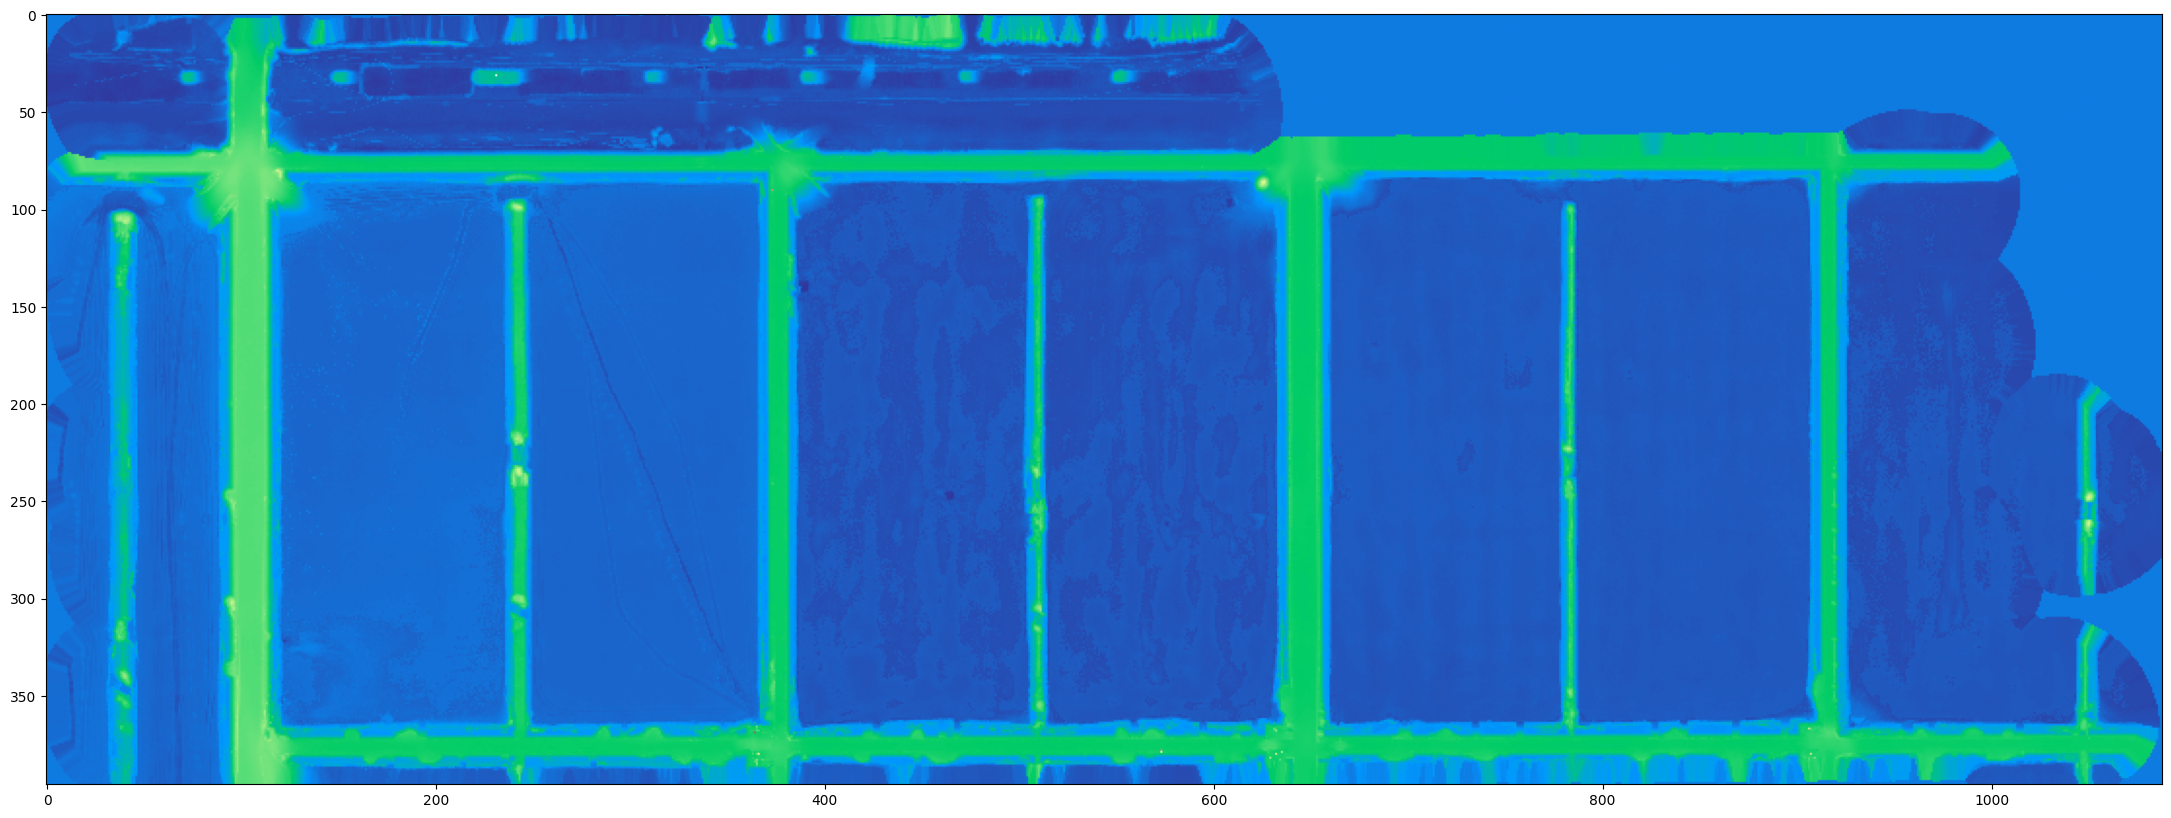

In [63]:
plt.figure(figsize=(50,10))
plt.imshow(np.load(name_file)['dem'], cmap='terrain') 
#plt.colorbar()
plt.show()

#plt.imshow(np.load(name_file)['mask'], cmap='gray') 
#plt.show()

In [73]:



pixels = dem_info['dem'].copy()
mask = np.zeros_like(pixels)

# Iterar sobre cada bounding box en el diccionario
for key, bb in pozas.items():
    # Determinar el grupo al que pertenece el bounding box
    grupo = key.split('.')[0]
    rasante = rasantes[grupo]

    (x1, y1), (x2, y2) = bb
    print((x1, y1), (x2, y2))
    for x in range(x1, x2):
        for y in range(y1, y2):
            pixel_value = pixels[y, x]
            new_pixel_value = max(0, pixel_value - rasante)
            pixels[y, x] = new_pixel_value
            mask[y, x] = 1
            break

pixels[mask == 0 ] = 0


plt.imshow(mask, cmap='grey')
plt.show()


(2464, 1760) (4608, 7216)


IndexError: index 1760 is out of bounds for axis 0 with size 396

In [ ]:
import cv2
img = np.load(name_file)['dem']
print(img.shape)

img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
img = img.astype(np.uint8)
cv2.imwrite('dem.png', img)

import numpy as np
import cv2
import rasterio
from rasterio.transform import from_origin


# Definir la transformación y el sistema de coordenadas (opcional)
transform = from_origin(0, 0, 1, 1)  # Ajusta según sea necesario
crs = 'EPSG:4326'  # Ajusta según sea necesario

# Guardar la imagen como un archivo TIFF
with rasterio.open('dem.tif', 'w', driver='GTiff',
                   height=img.shape[0], width=img.shape[1],
                   count=1, dtype=img.dtype,
                   crs=crs, transform=transform) as dst:
    dst.write(img, 1)

(7910, 21750)


/tmp/ipykernel_3433025/3494263277.py:5: RuntimeWarning: invalid value encountered in divide
  img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
/tmp/ipykernel_3433025/3494263277.py:6: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)
/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
